<a href="https://colab.research.google.com/github/Ziyi-star/Bachelorarbeit/blob/main/notebooks/training/train_simclr_har.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SimCLR Training

In [ ]:
# For VSCode
%load_ext autoreload
%autoreload 2

import os
import pickle
import scipy
import datetime
import numpy as np
import tensorflow as tf
import simclr_utitlities
import transformations
import simclr_models
import sys
import matplotlib.pyplot as plt

sys.path.append('../../')   # Add parent directory to Python path
working_directory = "../../models/"

seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)

# todo: Load data need to be changed according to your path
with open('../../data/TrainTest_one/X_train_data_normalized.pkl', 'rb') as f:
    np_train_data = pickle.load(f)
with open('../../data/TrainTest_one/y_train_label_onehot.pkl', 'rb') as f:
    np_train_labels = pickle.load(f)
np_train_data.shape, np_train_labels.shape

((848, 50, 3), (848, 7))

In [7]:
# For Google Colab
# 1. Clone your repository to go to access your notebook and .py files
!git clone https://github.com/Ziyi-star/Bachelorarbeit.git
# 2. Change working directory to where your notebook and .py files are
import os
os.chdir('/content/Bachelorarbeit/notebooks/training')
import os
import pickle
import scipy
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import simclr_utitlities
import transformations
import simclr_models
import sys

seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)

# Load data
# Download the file from GitHub
!wget https://raw.githubusercontent.com/Ziyi-star/Bachelorarbeit/main/notebooks/data_small/X_train_data_normalized.pkl
!wget https://raw.githubusercontent.com/Ziyi-star/Bachelorarbeit/main/notebooks/data_small/y_train_label_onehot.pkl

working_directory = "../models/"  # Relative path to models folder

# Load as usual
import pickle

with open('X_train_data_normalized.pkl', 'rb') as f:
    np_train_data = pickle.load(f)
with open('y_train_label_onehot.pkl', 'rb') as f:
    np_train_labels = pickle.load(f)

print(np_train_data.shape, np_train_labels.shape)


Cloning into 'Bachelorarbeit'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 211 (delta 65), reused 99 (delta 47), pack-reused 90 (from 1)
Receiving objects: 100% (211/211), 43.17 MiB | 26.95 MiB/s, done.
Resolving deltas: 100% (97/97), done.
--2025-09-09 08:47:55--  https://raw.githubusercontent.com/Ziyi-star/Bachelorarbeit/main/notebooks/data_small/X_train_data_normalized.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1017765 (994K) [application/octet-stream]
Saving to: ‘X_train_data_normalized.pkl.1’

X_train_data_normal 100%[===================>] 993.91K  --.-KB/s    in 0.03s   

2025-09-09 08:47:55 (28.1 MB/s) - ‘X_train_data_normalized.pkl.1’

In [8]:
# Parameters for all experiments
window_size = 50
input_shape = (window_size, 3)
batch_size = 512
#Number of samples processed together in one training step. Larger batch sizes can speed up training but require more memory.
decay_steps = 1000
#Number of steps after which the learning rate decays (used for learning rate scheduling).
epochs = 200
temperature = 0.1


In [9]:
# # transformation_indices = [2] # Use rotation transformation only
# # transformation_indices = [1, 2] # Use Scaling and rotation transformation
# transformation_indices = [5, 7] # Use channel shuffle and permutation transformation

# transform_funcs_vectorized = [
#     # 0. Adding random Gaussian noise.
#     transformations.noise_transform_vectorized,
#     # 1. Scaling by a random factor
#     transformations.scaling_transform_vectorized,
#     # 2. Applying a random 3D rotation
#     transformations.rotation_transform_vectorized,
#     # 3. Inverting the signals.
#     transformations.negate_transform_vectorized,
#     # 4. Reversing the direction of time
#     transformations.time_flip_transform_vectorized,
#     # 5. Randomly scrambling sections of the signal.
#     transformations.time_segment_permutation_transform_improved,
#     # 6. Stretching and warping the time-series
#     transformations.time_warp_transform_low_cost,
#     # 7. Shuffling the different channels.
#     transformations.channel_shuffle_transform_vectorized
# ]
# # transform_funcs_names = ['noised', 'scaled', 'rotated', 'negated', 'time_flipped', 'permuted', 'time_warped', 'channel_shuffled']
# # Optionally, you can use a combined transformation function for data augmentation.
# transformation_function = simclr_utitlities.generate_combined_transform_function(
#     transform_funcs_vectorized,
#     indices=transformation_indices
# )

In [10]:
#A parameter for the SimCLR loss function that controls how sharply similarities are measured.
# transform_funcs = [
#     transformations.scaling_transform_vectorized, # Use Scaling trasnformation
#     transformations.rotation_transform_vectorized # Use rotation trasnformation
# ]
transform_funcs = [
    transformations.time_segment_permutation_transform_improved,
    transformations.channel_shuffle_transform_vectorized
]
#List of data augmentation functions to apply to the input data. Here, only rotation is used.
transformation_function = simclr_utitlities.generate_composite_transform_function_simple(transform_funcs)

0 <function time_segment_permutation_transform_improved at 0x7e9cfff0d080>
1 <function channel_shuffle_transform_vectorized at 0x7e9cfff0cfe0>


In [11]:
# Time
start_time = datetime.datetime.now()
start_time_str = start_time.strftime("%Y%m%d-%H%M%S")
#Formats the date and time as a string like 20250827-153045 (for filenames, logs, etc.).
tf.keras.backend.set_floatx('float32')
#Sets TensorFlow to use 32-bit floating point numbers for all computations (standard for deep learning).


In [12]:
# Create a cosine-decayed learning rate schedule and SGD optimizer for training.
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

# Build the base model and attach the SimCLR head for contrastive learning.
base_model = simclr_models.create_base_model(input_shape, model_name="base_model")
simclr_model = simclr_models.attach_simclr_head(base_model)
simclr_model.summary()

# Train the SimCLR model using the specified transformation function and optimizer.
trained_simclr_model, epoch_losses = simclr_utitlities.simclr_train_model(
    simclr_model,
    np_train_data,
    optimizer,
    batch_size,
    transformation_function,
    temperature=temperature,
    epochs=epochs,
    is_trasnform_function_vectorized=True,
    verbose=1
)

# Save the trained SimCLR model to disk for later use.
simclr_model_save_path = f"{working_directory}{start_time_str}_simclr.hdf5"
trained_simclr_model.save(simclr_model_save_path)

Model: "base_model_simclr"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 50, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 27, 32)         │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 27, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 12, 64)         │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 5, 96)          │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 5, 96)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 96)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         6,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,594 (580.45 KB)

 Trainable params: 148,594 (580.45 KB)

 Non-trainable params: 0 (0.00 B)

epoch: 1 loss: 13.209
epoch: 2 loss: 12.406
epoch: 3 loss: 11.565
epoch: 4 loss: 12.528
epoch: 5 loss: 10.838
epoch: 6 loss: 10.137
epoch: 7 loss: 10.223
epoch: 8 loss: 10.215
epoch: 9 loss: 9.663
epoch: 10 loss: 10.093
epoch: 11 loss: 9.418
epoch: 12 loss: 10.190
epoch: 13 loss: 9.373
epoch: 14 loss: 9.639
epoch: 15 loss: 10.148
epoch: 16 loss: 9.455
epoch: 17 loss: 9.119
epoch: 18 loss: 9.137
epoch: 19 loss: 9.555
epoch: 20 loss: 9.194
epoch: 21 loss: 8.857
epoch: 22 loss: 8.879
epoch: 23 loss: 9.168
epoch: 24 loss: 9.336
epoch: 25 loss: 8.541
epoch: 26 loss: 8.544
epoch: 27 loss: 9.092
epoch: 28 loss: 9.474
epoch: 29 loss: 8.445
epoch: 30 loss: 8.875
epoch: 31 loss: 8.616
epoch: 32 loss: 8.621
epoch: 33 loss: 9.019
epoch: 34 loss: 8.379
epoch: 35 loss: 8.234
epoch: 36 loss: 8.392
epoch: 37 loss: 8.240
epoch: 38 loss: 8.399
epoch: 39 loss: 7.806
epoch: 40 loss: 9.360
epoch: 41 loss: 9.501
epoch: 42 loss: 8.468
epoch: 43 loss: 8.193
epoch: 44 loss: 8.024
epoch: 45 loss: 8.057
epoch: 4

epoch: 199 loss: 6.043
epoch: 200 loss: 5.956


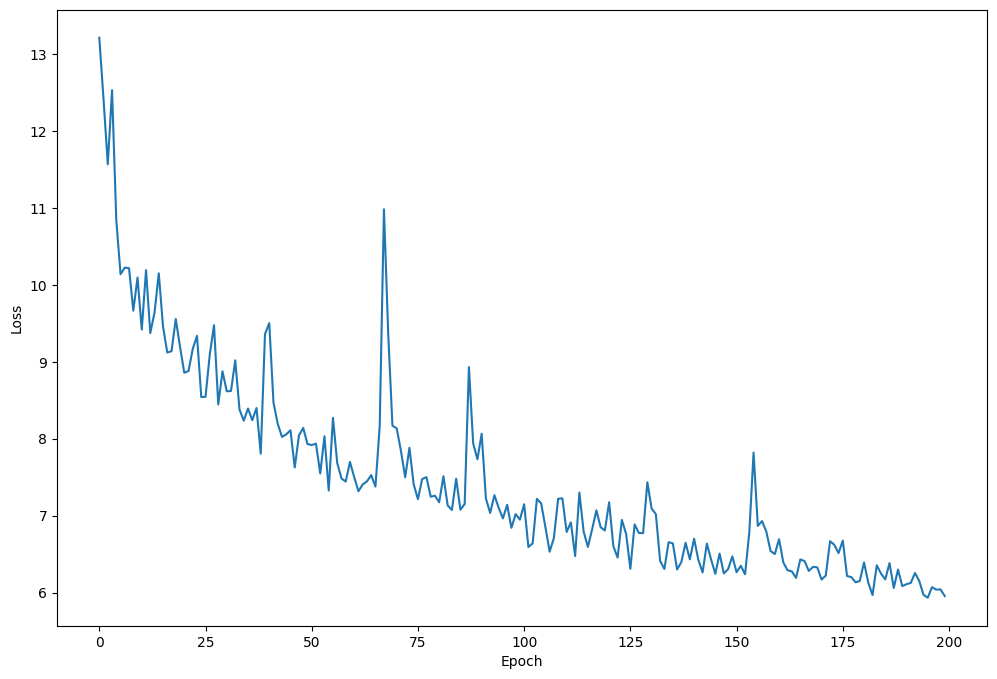

In [13]:
plt.figure(figsize=(12,8))
plt.plot(epoch_losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()